In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from voronoi_cells import random_voronoi_cells

In [2]:
def same(x,y):
    return (x and y) or ((not x) and (not y))
def switchaforb(lis,a,b):
    lis[lis.index(a)] = b

In [3]:
class VertexModel:
    #TODO compute energies

    def __init__(self, locs, adjs, boxsize=1., A0=1./12, p0=1., r=1.):
        self.v = [i.copy() for i in locs]
        self.adj = [i[:] for i in adjs]
        self.boxsize = boxsize
        self.A0 = A0
        self.p0 = p0
        self.r = r

        self.edgelens = [map(np.linalg.norm,self.get_edges(i)) for i in range(len(locs))]
        
        self.faces = self.find_all_faces()
        self.faceadj = self.make_faceadj()
        self.faceareas = map(self.get_facearea, range(len(self.faces)))
        self.perims = map(self.get_perim, range(len(self.faces)))
        
        self.energy = self.total_mechanical_energy()

        
    #Getters and setters
    def get_vert(self,idx):
        return self.v[idx].copy()
    def get_adj(self,idx):
        return self.adj[idx][:]
    def neighbors(self,idx):
        # returns neighbors of the vertex idx: list of positions.
        adjacency = self.adj[idx]
        return map(lambda x: self.v[x][:],adjacency)
    def get_edge(self,idx1,idx2):
        # returns the vector which points in the direction of idx1 to idx2 and has length equal to the edge length.
        # Use to correct for periodic boundary conditions.
        loc1 = self.get_vert(idx1)
        loc2 = self.get_vert(idx2)
        naive_edge = loc2-loc1
        #print naive_edge
        if np.linalg.norm(naive_edge)>self.boxsize/2.:
            if np.abs(naive_edge[0])>np.abs(naive_edge[1]):
                if naive_edge[0]>0:
                    loc2[0]-=self.boxsize
                else:
                    loc2[0]+=self.boxsize
                naive_edge = loc2-loc1
                if np.linalg.norm(naive_edge)>self.boxsize/2.:
                    if naive_edge[1]>0:
                        loc2[1]-=self.boxsize
                    else:
                        loc2[1]+=self.boxsize
            else:
                if naive_edge[1]>0:
                    loc2[1]-=self.boxsize
                else:
                    loc2[1]+=self.boxsize
                naive_edge = loc2-loc1
                if np.linalg.norm(naive_edge)>self.boxsize/2.:
                    if naive_edge[0]>0:
                        loc2[0]-=self.boxsize
                    else:
                        loc2[0]+=self.boxsize
        return loc2-loc1
    def get_edges(self,idx):
        # return all the edges from a single vertex
        loc = self.get_vert(idx)
        neighbors = self.get_adj(idx)
        return map(lambda x: self.get_edge(idx,x), neighbors)
    def get_face(self,v1,v2,v3):
        #return the actual face index containing those three vertices in order
        facetest = self.find_face(v1,v2,v3)
#         print facetest
        for f in range(len(self.faces)):
            if set(facetest)==set(self.faces[f]):
                return f
        print 'Not on the same face, I think'
    def replace_part_of_face(self,faceidx,find,replace):
        start = None
        end = None
#         print 'find:',find
#         print 'replace:',replace
#         print 'starting face:', self.faces[faceidx]
        for i in range(len(self.faces[faceidx])):
            if self.faces[faceidx][i]==find[0]:
                start = i
            elif self.faces[faceidx][i]==find[-1]:
                end = i
#         print start, end
        if end<start:
            newface = self.faces[faceidx][end+1:start]
        else:
            newface = self.faces[faceidx][end+1:]+self.faces[faceidx][:start]
#         print 'newface:',newface
        newface += replace
        self.faces[faceidx] = newface

    #Dealing with faces
    def find_face(self,v1,v2,v3):
        ## find the face that includes the three indices idx1-idx2-idx3
        edges2 = self.get_edges(v2)
        
        idx1_2 = self.get_adj(v2).index(v1)
        idx3_2 = self.get_adj(v2).index(v3)
        idxn_2 = [i for i in range(3) if (i!=idx1_2 and i!=idx3_2)][0]
        
        #cw or ccw
        ccw = False
        angles2 = [np.arctan2(x[1],x[0]) for x in edges2]
        #print angles2
        if same((angles2[idx3_2]>angles2[idxn_2]),(angles2[idxn_2]>angles2[idx1_2])):
            #print 'between'
            if angles2[idx3_2]>angles2[idx1_2]:
                ccw = False
            else:
                ccw = True
        else:
            if angles2[idx3_2]>angles2[idx1_2]:
                ccw = True
            else:
                ccw = False
        
        #print ccw
        #travel around the face and get the vertices
        face = [v1, v2, v3]
        prev_vertex = v2
        current_vertex = v3

        while current_vertex!=v1:
            #get the other two neighbors
            adj = self.get_adj(current_vertex)
            edg = self.get_edges(current_vertex)
            angs = [np.arctan2(x[1],x[0]) for x in edg]
            
            idx_next = range(3)
            idx_prev = adj.index(prev_vertex)
            #print adj
            idx_next.remove(idx_prev)
            
            if same((angs[idx_next[0]]>angs[idx_prev]),(angs[idx_prev]>angs[idx_next[1]])):
                if angs[idx_next[0]]>angs[idx_next[1]]:
                    if ccw:
                        face+=[adj[idx_next[0]]]
                    else:
                        face+=[adj[idx_next[1]]]
                else:
                    if not ccw:
                        face+=[adj[idx_next[0]]]
                    else:
                        face+=[adj[idx_next[1]]]
            else:
                if angs[idx_next[0]]>angs[idx_next[1]]:
                    if not ccw:
                        face+=[adj[idx_next[0]]]
                    else:
                        face+=[adj[idx_next[1]]]
                else:
                    if ccw:
                        face+=[adj[idx_next[0]]]
                    else:
                        face+=[adj[idx_next[1]]]
            
            prev_vertex = current_vertex
            current_vertex = face[-1]
            #print current_vertex
        if not ccw:
            return face[:-1]
        else:
            return face[-1:0:-1]
    def find_all_faces(self):
        #goes along each edge to search for all the faces. 
        #Returns a list of faces, each represented by a list of vertices
        faces = []
        facesets = []
        for v in range(len(self.v)):
            n = self.adj[v]
            for w in n:
                n2 = [i for i in self.adj[w] if i!=v]
                #print v,w,n2[0]
                #print v,w,n2[1]
                face0 = self.find_face(v,w,n2[0])
                face1 = self.find_face(v,w,n2[1])
                if set(face0) not in facesets:
                    faces+= [face0]
                    facesets+=[set(face0)]
                if set(face1) not in facesets:
                    faces+= [face1]
                    facesets+=[set(face1)]
                
        return faces
    def make_faceadj(self):
        #makes a list of face indices by vertex: each vertex is part of three faces.
        faceadj = [[] for i in range(len(self.v))]
        for faceidx in range(len(self.faces)):
            for v in self.faces[faceidx]:
                faceadj[v]+=[faceidx]
        return faceadj
    def get_facearea(self,idx):
        face = self.faces[idx]
        vertices = [np.array([0.,0.])]
        this_v = np.array([0.,0.])
        for i in range(len(face)-1):
            edge = self.get_edge(face[i],face[i+1])
            #print edge
            this_v = this_v + edge
            vertices.append(this_v[:])
        #print vertices
        return VertexModel.PolygonArea(vertices)
    def get_faceverts(self,face):
        vertices = [np.array([0.,0.])]
        this_v = np.array([0.,0.])
        facee = face+[face[0]]
        for i in range(len(face)):
            edge = self.get_edge(facee[i],facee[i+1])
            #print edge
            this_v = this_v + edge
            vertices.append(this_v[:])
        verts = np.array(vertices)
        #plt.figure()
        #plt.quiver(verts[:-1,0], verts[:-1,1], verts[1:,0]-verts[:-1,0], verts[1:,1]-verts[:-1,1], scale_units='xy', angles='xy', scale=1)

        return vertices
    def get_perim(self,idx):
        #perimeter of face idx
        face = self.faces[idx]
        perim = 0
        for i in range(len(face)):
            edge = self.get_edge(face[i-1],face[i])
            #print edge
            perim+=np.linalg.norm(edge)
        #print vertices
        return perim
    def rotate_face(self,face_idx,v_idx):
        #return a rotation of the face such that v_idx is not at the end
        face_init = self.faces[face_idx][:]
        if face_init[0]==v_idx:
            return [face_init[-1]]+face_init[0:-1]
        elif face_init[-1]==v_idx:
            return face_init[1:]+[face_init[0]]
        else:
            return face_init
    def wrap_to_box(self,loc):
        if loc[0]<0:
            loc[0]+=self.boxsize
        elif loc[0]>self.boxsize:
            loc[0]-=self.boxsize
        
        if loc[1]<0:
            loc[1]+=self.boxsize
        elif loc[1]>self.boxsize:
            loc[1]-=self.boxsize
            
    #moving vertices
    def move_vertex(self,idx,newpos):
        for i in range(2):
            if newpos[i]>self.boxsize:
                newpos[i] -= self.boxsize
            elif newpos[i]<0:
                newpos[i] += self.boxsize
        self.v[idx] = newpos
        self.edgelens[idx] = map(np.linalg.norm, self.get_edges(idx))
        for i in self.adj[idx]:
            self.edgelens[i] = map(np.linalg.norm, self.get_edges(i))
        for i in self.faceadj[idx]:
            self.faceareas[i] = self.get_facearea(i)
            self.perims[i] = self.get_perim(i)
        self.energy = self.total_mechanical_energy()
    #Computing energies
    def total_mechanical_energy(self):
        A0 = self.A0
        p0 = self.p0
        r = self.r
        
        a_tilde = np.array(self.faceareas)/A0
        p_tilde = np.array(self.perims)/np.sqrt(A0)
        
        return np.sum(np.power(a_tilde-1,2) + np.power(p_tilde-p0,2)/r)
    
    #In-plane terms in the gradient that can be passed up to the apicobasal model
    def del_A(self,v_idx, f_idx):
        #gradient of A for the face f_idx with respect to moving vertex v_idx
        adj = self.adj[v_idx]
        face =  self.rotate_face(f_idx,v_idx)
        full_face = self.get_faceverts(self.faces[f_idx])
        v = full_face[face.index(v_idx)]
        face = [full_face[i] for i in range(len(face)) if face[i] in adj]

        dAdx = 0.5*VertexModel.ShoelaceSign(full_face)*(face[1][1]-face[0][1])
        dAdy = 0.5*VertexModel.ShoelaceSign(full_face)*(face[0][0]-face[1][0])

        return np.array([dAdx, dAdy])

    def del_l(self,v1,v2):
        #gradient of the length of the edge between v1 and v2, wrt moving v1.
        edge = self.get_edge(v2,v1)
        l = np.linalg.norm(edge)
        return 1./l*np.array([edge[0],edge[1]])
    #Gradient descent
    def gradient_one_vertex(self,idx):
        adj = self.adj[idx]
        
        
        faceadj = self.faceadj[idx]
        #faces is a list of vertex indices
        faces =  map(lambda x: self.rotate_face(x,idx), faceadj)
        
        #full_faces is the list of positions
        full_faces =  map(lambda x: self.get_faceverts(x), faces)
        
        v = map(lambda x: full_faces[x][faces[x].index(idx)], range(len(faces)))
        #print 'v:',v
        #print faces
        #print full_faces
        #faces is now the two positions that are adjacent to vertex idx, in the order they appear in full_faces
        faces = map(lambda x: [full_faces[x][i] for i in range(len(faces[x])) if faces[x][i] in adj], range(len(faces)))
        #print 'faces',faces
        
        a_tildes = np.array(map(lambda x: self.faceareas[x]/self.A0, faceadj))
        p_tildes = np.array(map(lambda x: self.perims[x]/np.sqrt(self.A0), faceadj))
        
        def dpdx(x):
            x1 = 1/np.sqrt(self.A0)*((v[x][0]-faces[x][0][0])/np.linalg.norm(v[x]-faces[x][0]))
            if (v[x][0]-faces[x][0][0])==0:
                x1=0
            x2 = 1/np.sqrt(self.A0)*(v[x][0]-faces[x][1][0])/np.linalg.norm(v[x]-faces[x][1])
            if (v[x][0]-faces[x][1][0])==0:
                x2 = 0
            return x1+x2
        def dpdy(x):
            x1 = 1/np.sqrt(self.A0)*((v[x][1]-faces[x][0][1])/np.linalg.norm(v[x]-faces[x][0]))
            if (v[x][1]-faces[x][0][1])==0:
                x1=0
            x2 = 1/np.sqrt(self.A0)*(v[x][1]-faces[x][1][1])/np.linalg.norm(v[x]-faces[x][1])
            if (v[x][1]-faces[x][1][1])==0:
                x2 = 0
            return x1+x2
        
        dadx_comps = np.array(map(lambda x: 0.5/self.A0*VertexModel.ShoelaceSign(full_faces[x])*(faces[x][1][1]-faces[x][0][1]), range(len(faces))))
        #print 'dadx:',dadx_comps
        dpdx_comps = np.array(map(dpdx, range(len(faces))))
        #print 'dpdx:',dpdx_comps
        dady_comps = np.array(map(lambda x: 0.5/self.A0*VertexModel.ShoelaceSign(full_faces[x])*(faces[x][0][0]-faces[x][1][0]), range(len(faces))))
        #print 'dady:',dady_comps
        dpdy_comps = np.array(map(dpdy, range(len(faces))))
        
        
        #print v[0][1]-faces[0][0][1]
        #print v[0][1]-faces[0][1][1]
        #print 'dpdy:',dpdy_comps
        gradient = np.array([2*np.dot((a_tildes-1),dadx_comps)+2/self.r*np.dot((p_tildes-self.p0),dpdx_comps), 
                             2*np.dot((a_tildes-1),dady_comps)+2/self.r*np.dot((p_tildes-self.p0),dpdy_comps)])

        return gradient
    def gradient_descent_one_vertex(self,idx, gamma):
        # move a vertex against the energy gradient
        gradient = self.gradient_one_vertex(idx)
        #print gradient
        
        #update position, edge lengths, face areas
        newpos = self.v[idx]-gamma*gradient
        E = self.energy
        self.move_vertex(idx,newpos)
        #print E-self.energy
        return self.energy-E

    def gradient_descent_step(self, gamma):
        for i in range(len(self.v)):
            step = self.gradient_descent_one_vertex(i, gamma)
        return step

    def gradient_descent_no_t1(self, gamma, tol):
        step = 2*tol
        while abs(step)>tol:
            step = self.gradient_descent_step(gamma)
            if step>0:
                print 'ascending'
                
    def evaluate_t1_trans(self,gamma,l_crit,i,k):
        # run a simulation with and without the T1 transition to figure out which one is energetically more favorable
        edgelens_copy = [x[:] for x in self.edgelens]
        faces_copy = [x[:] for x in self.faces]
#         print self.faces
        faceadj_copy = [x[:] for x in self.faceadj]
        faceareas_copy = self.faceareas[:]
        perims_copy = self.perims[:]
        adj_copy = [x[:] for x in self.adj]
        v_copy = [x.copy() for x in self.v]
        
        gradient_i = self.gradient_one_vertex(i)
        gradient_k = self.gradient_one_vertex(k)
        i_to_k = self.get_edge(i,k)
        k_to_i = -i_to_k
        E_notrans = self.total_mechanical_energy()
        #if the gradients were pushing the vertices together anyway
#         if np.dot(gradient_i,i_to_k)<0 and np.dot(gradient_k, k_to_i)<0:
        dis1, dis2 = self.t1_trans_2(i,k)
        self.move_vertex(i,self.v[i]+dis1)
        self.move_vertex(k,self.v[k]+dis2)
#         print i,k
#         self.show_model()
#         plt.show()
        E_withtrans = self.total_mechanical_energy()
#         print self.faces
        if E_withtrans>E_notrans:
#             print 'transition aint for me'
            self.edgelens = edgelens_copy
            self.faces = faces_copy
            self.faceadj = faceadj_copy
            self.faceareas = faceareas_copy
            self.perims = perims_copy
            self.adj = adj_copy
            self.energy = E_notrans
            self.v = v_copy
#             print self.faces
            return 0
#         print 'ok guess I\'ll switch'
        self.energy = E_withtrans
        return 1
    def gradient_descent_with_t1(self, gamma, tol, l_crit):
        step = 2*tol
        total_trans = 0
        while abs(step)>tol:
            step = self.gradient_descent_step(gamma)
            for i in range(len(self.v)):
                for j in range(3):
                    if self.edgelens[i][j]<l_crit:
#                         print i,self.adj[i][j]
                        E_i = self.energy
                        k = self.adj[i][j]
                        total_trans += self.evaluate_t1_trans(gamma, l_crit,i,k)
            if step>0:
                print 'ascending'
        print 'total T1 transitions:',total_trans

    #Topological transition
    def t1_trans_2(self,idx1,idx2):
        edge = self.get_edge(idx1,idx2)
        loc1 = self.get_vert(idx1)
        loc2 = self.get_vert(idx2)
        if np.linalg.norm(loc1-loc2)>self.boxsize/2.:
            return
        loc_new = (loc1+loc2)/2
        
        self.v[idx1] = loc_new.copy()
        self.v[idx2] = loc_new.copy()
        neighbors1 = [x for x in self.get_adj(idx1) if x!=idx2]
        neighbors2 = [x for x in self.get_adj(idx2) if x!=idx1]
        
        #order the neighbors clockwise:
        n = neighbors1 + neighbors2
        self.v[idx1] = loc_new.copy()
        self.v[idx2] = loc_new.copy()
        nlocs = [self.get_edge(idx1,i) for i in neighbors1] + [self.get_edge(idx2,i) for i in neighbors2]
        self.v[idx1] = loc1
        self.v[idx2] = loc2
        nangs = [np.arctan2(i[1],i[0]) for i in nlocs]
        sort_indices = sorted(range(len(nangs)),key = lambda x: nangs[x])
        n_sorted = [n[x] for x in sort_indices]
        nlocs_sorted = [nlocs[x] for x in sort_indices]
        #print n_sorted
        for shift in range(4):
            if (n_sorted[-shift] in neighbors1) and (n_sorted[-shift+1] in neighbors1):
                n_sorted = n_sorted[-shift:] + n_sorted[0:4-shift]
                break 
#         print neighbors1, neighbors2, n_sorted
        v10 = n_sorted[0]
        v11 = n_sorted[1]
        v20 = n_sorted[2]
        v21 = n_sorted[3]
        #switch neighbors:
        A = self.get_face(n_sorted[0],idx1,n_sorted[1])
        B = self.get_face(idx2,idx1,n_sorted[1])
        C = self.get_face(idx1,idx2,n_sorted[3])
        D = self.get_face(n_sorted[2],idx2,n_sorted[3])
#         print A,B,C,D

        self.v[idx1] = loc_new.copy()
        self.v[idx2] = loc_new.copy()

        #update adjacencies
        neighbors1 = [idx2,n_sorted[3],n_sorted[0]]
        neighbors2 = [idx1,n_sorted[1],n_sorted[2]]
        self.adj[idx1] = neighbors1
        self.adj[idx2] = neighbors2
        self.adj[n_sorted[1]][self.adj[n_sorted[1]].index(idx1)] = idx2
        self.adj[n_sorted[3]][self.adj[n_sorted[3]].index(idx2)] = idx1

        #update edgelens
        
        self.edgelens[idx1] = map(np.linalg.norm,self.get_edges(idx1))
        self.edgelens[idx2] = map(np.linalg.norm,self.get_edges(idx2))
        self.edgelens[n_sorted[0]] = map(np.linalg.norm,self.get_edges(n_sorted[0]))
        self.edgelens[n_sorted[1]] = map(np.linalg.norm,self.get_edges(n_sorted[1]))
        self.edgelens[n_sorted[2]] = map(np.linalg.norm,self.get_edges(n_sorted[2]))
        self.edgelens[n_sorted[3]] = map(np.linalg.norm,self.get_edges(n_sorted[3]))
        
        #update faces and faceadj
        self.replace_part_of_face(A,[v11,idx1,v10],[v11,idx2,idx1,v10])
        self.replace_part_of_face(B, [v20,idx2,idx1,v11],[v20,idx2,v11])
        #update locations
        self.replace_part_of_face(C,[v10,idx1,idx2,v21],[v10,idx1,v21])
        self.replace_part_of_face(D, [v21,idx2,v20],[v21,idx1,idx2,v20])
        
        #update faceadj
        switchaforb(self.faceadj[idx1], B, D)
        switchaforb(self.faceadj[idx2], C, A)
        
        #update faceareas
        self.faceareas[A] = self.get_facearea(A)
        self.faceareas[B] = self.get_facearea(B)
        self.faceareas[C] = self.get_facearea(C)
        self.faceareas[D] = self.get_facearea(D)

        #update perims
        self.perims[A] = self.get_perim(A)
        self.perims[B] = self.get_perim(B)
        self.perims[C] = self.get_perim(C)
        self.perims[D] = self.get_perim(D)
        
        #return vectors pointing away from the junction
        pointing_away_1 = np.dot([[0,-1],[1,0]], edge)/2.
        pointing_away_2 = np.dot([[0,-1],[1,0]], -edge)/2.
        
        return (pointing_away_1, pointing_away_2)
    #useful helper functions
    def show_model(self):
        #draw the vertex model
        varray = np.array(self.v)
        for i in range(len(self.v)):
            vv = self.v[i]
            es = self.get_edges(i)
            [plt.plot([vv[0],vv[0]+e[0]],[vv[1],vv[1]+e[1]],color='k') for e in es]
        plt.scatter(varray[:,0],varray[:,1])
        for i in range(len(self.v)):
            plt.annotate(str(i),xy=tuple(self.v[i]), xytext=tuple(np.array([0.02,0.02])+self.v[i]))
        plt.xlim([0,self.boxsize])
        plt.ylim([0,self.boxsize])
        plt.gca().set_aspect('equal')
     
    @staticmethod
    def PolygonArea(list_of_points):
        corners = np.array(list_of_points)
        n = len(corners) # of corners
        area = 0.0
        for i in range(n):
            j = (i + 1) % n
            area += corners[i][0] * corners[j][1]
            area -= corners[j][0] * corners[i][1]
        area = abs(area) / 2.0
        return area

    @staticmethod
    def ShoelaceSign(list_of_points):
        corners = np.array(list_of_points)
        n = len(corners) # of corners
        area = 0.0
        for i in range(n):
            j = (i + 1) % n
            area += corners[i][0] * corners[j][1]
            area -= corners[j][0] * corners[i][1]
        #print area
        return -((area>0)-0.5)*2

In [158]:
locs,adjs = random_voronoi_cells(4)

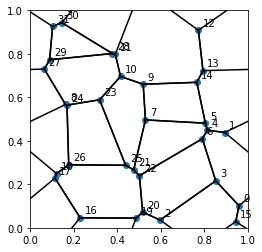

initial energy: 102.651819225
total T1 transitions: 5


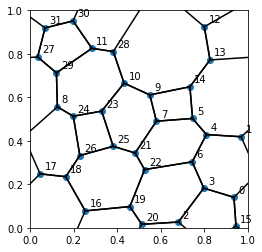

final energy: 86.7046511868


In [159]:
vm2d = VertexModel(locs,adjs)
vm2d.show_model()
plt.show()
print 'initial energy:',vm2d.total_mechanical_energy()
vm2d.gradient_descent_with_t1(0.00001,0.0001, 0.05)
vm2d.show_model()
plt.show()
print 'final energy:',vm2d.total_mechanical_energy()

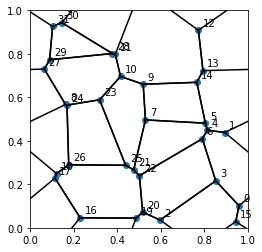

initial energy: 102.651819225


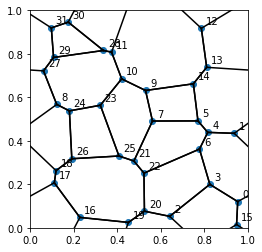

final energy: 92.5952399448


In [161]:
vm2d = VertexModel(locs,adjs)
vm2d.show_model()
plt.show()
print 'initial energy:',vm2d.total_mechanical_energy()
vm2d.gradient_descent_no_t1(0.00001,0.0001)
vm2d.show_model()
plt.show()
print 'final energy:',vm2d.total_mechanical_energy()

In [87]:
np.transpose(np.rot90(np.transpose([[0,2]]),2))[0]

array([2, 0])